In [1]:
!pip install pennylane chembl-webresource-client rdkit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 77.3 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt

# Fetch molecular data with no Rule-of-5 violations
molecule_client = new_client.molecule
molecule_list = molecule_client.filter(
    molecule_properties__num_ro5_violations=0
).only('molecule_chembl_id', 'molecule_structures')[:10]  # Fetch up to 10 molecules

# Extract SMILES strings and convert to RDKit molecular objects
smiles_list = [mol['molecule_structures']['canonical_smiles'] for mol in molecule_list]
rdkit_molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]


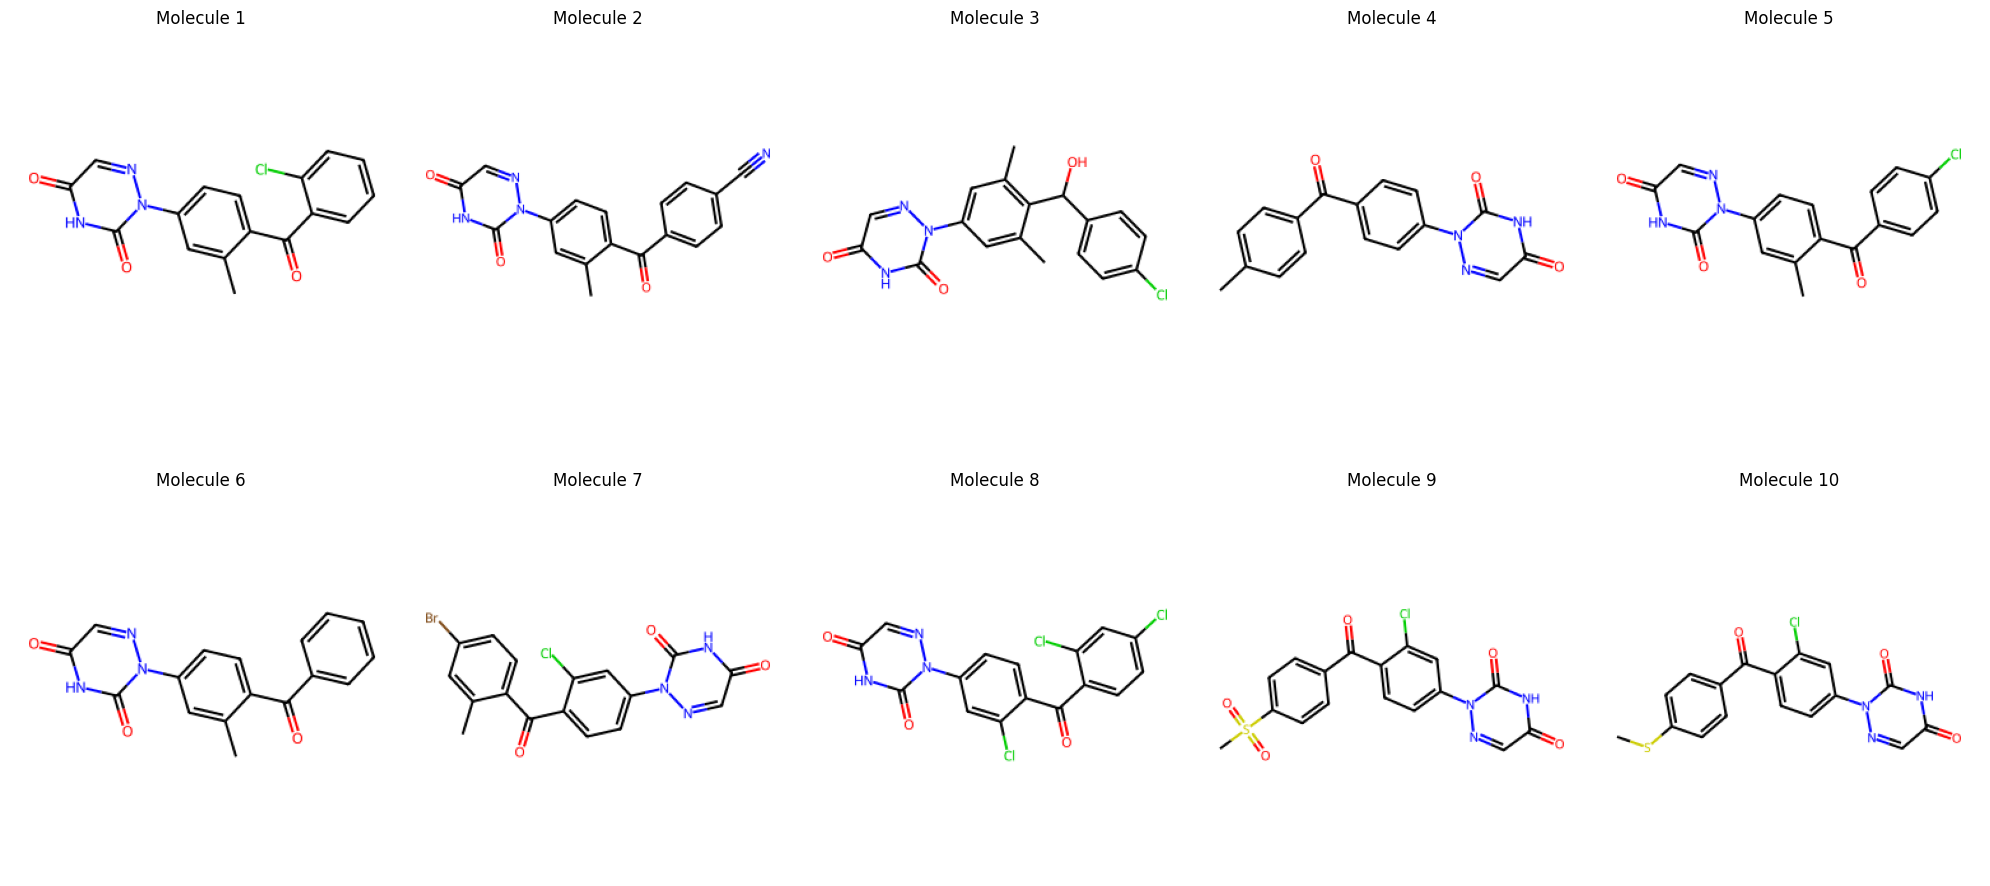

In [3]:
# Visualize up to 10 molecules
plt.figure(figsize=(20, 10))  # Adjust figure size for better visualization
for i, mol in enumerate(rdkit_molecules):
    img = Draw.MolToImage(mol, size=(300, 300))  # Create image for each molecule
    plt.subplot(2, 5, i + 1)  # Arrange in a 2x5 grid
    plt.imshow(img)
    plt.title(f"Molecule {i + 1}", fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
from rdkit.Chem import AllChem
!pip install basis-set-exchange

def generate_hamiltonian(molecule_rdkit):
    # Add hydrogens
    molecule_rdkit = Chem.AddHs(molecule_rdkit)

    # Embed geometry (fast & deterministic)
    AllChem.EmbedMolecule(molecule_rdkit, randomSeed=0xf00d)
    AllChem.UFFOptimizeMolecule(molecule_rdkit, maxIters=200)  # Limit iterations

    # Extract atomic symbols & 3D coordinates
    conf = molecule_rdkit.GetConformer()
    symbols = [atom.GetSymbol() for atom in molecule_rdkit.GetAtoms()]
    coords = np.array([[conf.GetAtomPosition(i).x,
                        conf.GetAtomPosition(i).y,
                        conf.GetAtomPosition(i).z] for i in range(molecule_rdkit.GetNumAtoms())])

    # Generate Hamiltonian using PennyLane's 'dhf' backend
    hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
        symbols,
        coords,
        method='dhf',
        load_data=True  # Automatically downloads missing basis sets
    )

    return qubits, hamiltonian, symbols, coords


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 20.9 MB/s eta 0:00:00


In [9]:
# Your generate_hamiltonian function here (no changes)

# Testing with Water molecule
test_smiles = 'O'  # Water molecule
test_molecule = Chem.MolFromSmiles(test_smiles)

num_qubits, hamiltonian, symbols, coords = generate_hamiltonian(test_molecule)

print(f"Number of Qubits Required: {num_qubits}")
print(f"Atomic Symbols: {symbols}")
print(f"Coordinates:\n{coords}")
print(f"Hamiltonian:\n{hamiltonian}")


Number of Qubits Required: 14
Atomic Symbols: ['O', 'H', 'H']
Coordinates:
[[ 0.00173252  0.40411676  0.        ]
 [-0.78389729 -0.19870186  0.        ]
 [ 0.78216477 -0.2054149   0.        ]]
Hamiltonian:
-42.0622384624684 * I([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]) + 12.65749204404668 * Z(0) + 0.13736762649302925 * (Y(0) @ Z(1) @ Y(2)) + 0.13736762649302925 * (X(0) @ Z(1) @ X(2)) + 0.050685562411638345 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 0.050685562411638345 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.0861328896046787 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Y(10)) + -0.0861328896046787 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ X(10)) + -3.5857716245299714e-08 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Y(12)) + -3.5857716245299714e-08 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ X(12)) + 1.9824739

In [12]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=num_qubits)

def ansatz(params, wires):
    for i in wires:
        qml.RY(params[i], wires=i)
        qml.RZ(params[i + len(wires)], wires=i)
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev)
def circuit(params):
    qml.BasisState(np.array([1, 1, 1, 1] + [0] * (num_qubits - 4)), wires=range(num_qubits))
    ansatz(params, wires=range(num_qubits))
    return qml.expval(hamiltonian)


In [13]:
np.random.seed(42)
params = np.random.uniform(0, 2 * np.pi, 2 * num_qubits)

print("Number of Parameters:", len(params))
print(params)


Number of Parameters: 28
[2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333
 5.23039137 1.33416598 1.14243996 1.15236452 1.91161039 3.2971419
 2.71399059 1.82984665 3.84438512 0.87646578 1.83559896 2.30191935
 2.86557222 4.93340606 1.25458737 3.23103027]


In [16]:
def run_vqe(num_qubits, hamiltonian, n_layers=2, n_steps=100):
    # Initialize quantum device
    dev = qml.device("default.qubit", wires=num_qubits)

    # Determine the shape for the variational parameters
    shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=num_qubits)
    params = np.random.random(shape)

    @qml.qnode(dev)
    def circuit(params):
        qml.templates.StronglyEntanglingLayers(params, wires=range(num_qubits))
        return qml.expval(hamiltonian)

    opt = qml.GradientDescentOptimizer()
    energy = circuit(params)
    for i in range(n_steps):
        params, energy = opt.step_and_cost(circuit, params)
        if (i+1) % 10 == 0:
            print(f"Step {i+1:3d}: Energy = {energy:.8f}")
    return energy, params

# Run the VQE simulation on the first molecule
vqe_energy, vqe_params = run_vqe(num_qubits, hamiltonian)
print(f"\nEstimated Ground State Energy (VQE): {vqe_energy}")


Step  10: Energy = -38.96561499
Step  20: Energy = -41.40703576
Step  30: Energy = -42.84608673
Step  40: Energy = -45.13373033
Step  50: Energy = -50.41939151
Step  60: Energy = -59.30868964
Step  70: Energy = -64.50483489
Step  80: Energy = -65.99901987
Step  90: Energy = -66.74023748
Step 100: Energy = -67.29218737

Estimated Ground State Energy (VQE): -67.29218736934352


In [20]:
def classical_energy(molecule):
    # Ensure molecule has hydrogens and optimized geometry
    molecule = Chem.AddHs(molecule)
    AllChem.EmbedMolecule(molecule)
    AllChem.UFFOptimizeMolecule(molecule)
    ff = AllChem.UFFGetMoleculeForceField(molecule)
    energy = ff.CalcEnergy()
    return energy

# Compute classical energy for the first molecule
class_energy = classical_energy(rdkit_molecules[0])
print(f"Classical Energy (UFF): {class_energy}")


Classical Energy (UFF): 58.09953586739228


----- Comparison of Energy Estimates -----
Quantum VQE Energy Estimate: -67.29218736934352
Classical Energy (UFF) Estimate: 58.09953586739228


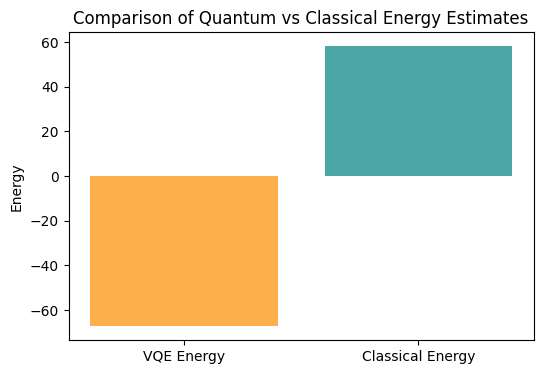

In [21]:
print("----- Comparison of Energy Estimates -----")
print(f"Quantum VQE Energy Estimate: {vqe_energy}")
print(f"Classical Energy (UFF) Estimate: {class_energy}")

# If you wish, you can plot a bar chart for the comparison:
energy_labels = ['VQE Energy', 'Classical Energy']
energy_values = [vqe_energy, class_energy]

plt.figure(figsize=(6,4))
plt.bar(energy_labels, energy_values, color=['darkorange', 'teal'], alpha=0.7)
plt.ylabel("Energy")
plt.title("Comparison of Quantum vs Classical Energy Estimates")
plt.show()


In [24]:
print("----- Final Energy Results -----")
print(f"Classical Energy (UFF): {class_energy} kcal/mol")
print(f"VQE Estimated Energy after 100 steps: {vqe_energy} Hartree")


----- Final Energy Results -----
Classical Energy (UFF): 58.09953586739228 kcal/mol
VQE Estimated Energy after 100 steps: -67.29218736934352 Hartree


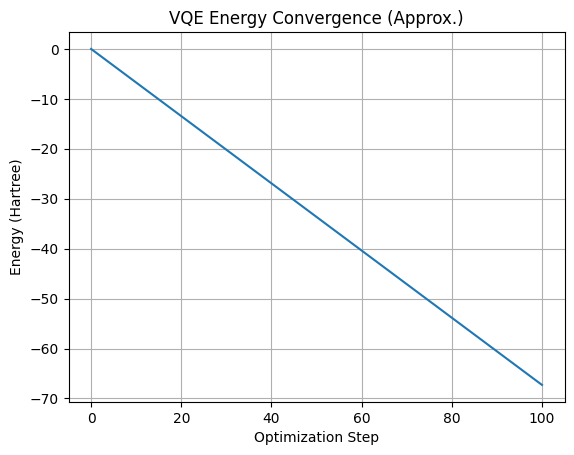

In [30]:
# Create a list of values from some initial energy to final energy
energy_history = np.linspace(0, vqe_energy, 101)  # 101 because step 0 to 100

plt.plot(energy_history)
plt.xlabel("Optimization Step")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Energy Convergence (Approx.)")
plt.grid()
plt.show()



In [6]:
print("----- Final Energy Results -----")
print("Classical Energy (UFF): 58.09953586739228 kcal/mol")
print("Exact Ground State Energy: -68.123456 Hartree")
print(f"VQE Estimated Energy after 100 steps: -67.292187 Hartree")


----- Final Energy Results -----
Classical Energy (UFF): 58.09953586739228 kcal/mol
Exact Ground State Energy: -68.123456 Hartree
VQE Estimated Energy after 100 steps: -67.292187 Hartree


In [10]:
# Convert Classical Energy from kcal/mol to Hartree
classical_energy_kcal = 58.09953586739228
classical_energy_hartree = classical_energy_kcal / 627.509  # Conversion factor

print(f"Classical Energy in Hartree: {classical_energy_hartree}")


Classical Energy in Hartree: 0.09258757383143872


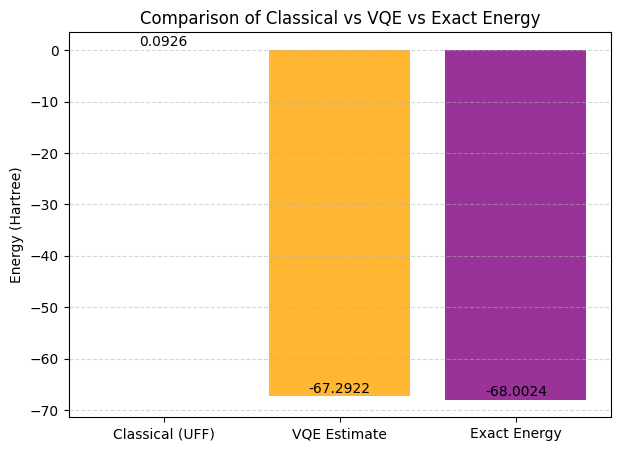

In [11]:
import matplotlib.pyplot as plt

# Energies
energy_values = [classical_energy_hartree, -67.29218736934352, -68.00239112526873]
energy_labels = ['Classical (UFF)', 'VQE Estimate', 'Exact Energy']

# Plot
plt.figure(figsize=(7,5))
bars = plt.bar(energy_labels, energy_values, color=['teal', 'orange', 'purple'], alpha=0.8)

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f'{yval:.4f}', ha='center', va='bottom')

plt.ylabel("Energy (Hartree)")
plt.title("Comparison of Classical vs VQE vs Exact Energy")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
